In [1]:
import mellon
import pickle
import scanpy as sc
import magic
import seaborn as sns
import networkx as nx
import oslom
from argparse import Namespace
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d.art3d import LineCollection
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import NearestNeighbors


def sanitize_types_for_h5(adata):
    adata.var=adata.var.convert_dtypes()
    adata.obs=adata.obs.convert_dtypes()

    for c,t in zip(adata.obs.columns,adata.obs.dtypes):
        adata.obs[c]=adata.obs[c].to_list()
        if t == object:
            print(c,t)
            adata.obs[c]=pd.to_numeric(adata.obs[c], errors='coerce')

    for c,t in zip(adata.var.columns,adata.var.dtypes):
        adata.var[c]=adata.var[c].to_list()
        if t == object:
            print(c,t)
            adata.var[c]=pd.to_numeric(adata.var[c], errors='coerce')
    
    if adata.raw is not None:
        adata.raw.var.columns = adata.raw.var.columns.astype(str)
        for c,t in zip(adata.raw.var.columns,adata.raw.var.dtypes):
            adata.raw.var[c]=adata.raw.var[c].to_list()
            if t == object:
                adata.var[c]=pd.to_numeric(adata.raw.var[c], errors='coerce')
    
    adata.obs=adata.obs.fillna(np.nan)
    adata.var=adata.var.fillna(np.nan)
    adata.var.columns = adata.var.columns.astype(str)
    adata.obs.columns = adata.obs.columns.astype(str)
    return(adata)

def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    result = [bind.get(itm, None) for itm in a]  # None can be replaced by any other "not in b" value
    result = [result, [not x is None for x in result]]
    return result

def norm_log_transform(adata_local, size_factors, cell_filter):
    if(len(cell_filter) > 0):
        adata_local = adata_local[cell_filter,:].copy()
        size_factors = np.array(size_factors)[cell_filter]
    else:
        adata_local = adata_local.copy()
    print("Normalizing data")
    if(scipy.sparse.issparse(adata_local.X)):
        c = scipy.sparse.diags(1/size_factors)
        adata_local.X = c * adata_local.X * np.median(size_factors)
    else:
        adata_local.X = adata_local.X / size_factors[:,None] * np.median(size_factors)
    
    print("Log transform with pseudocount 1")
    sc.pp.log1p(adata_local)
    return(adata_local)


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [72]:
genes = pd.read_table('GSE141259_HighResolution_genes.txt', header = None)
cells = pd.read_table('GSE141259_HighResolution_barcodes.txt', header = None)
info = pd.read_table('GSE141259_HighResolution_cellinfo.csv')

In [15]:
adata = sc.read_mtx('GSE141259_HighResolution_rawcounts.mtx')

In [19]:
adata.obs_names =  cells[0]
adata.var_names =  genes[0]
adata.obs = info
adata.obsm['X_umap'] = adata.obs[['umap_1', 'umap_2']].values

In [116]:
adata.obs['time_point'] = adata.obs['time_point'].astype('str')
adata.obs.loc[adata.obs['time_point'] == 'd14_PBS', 'time_point'] = 'Control'

from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Control', 'day 2', 'day 3', 'day 4', 'day 5',
                                        'day 6', 'day 7', 'day 8', 'day 9', 'day 10', 'day 11', 'day 12',
                                        'day 13', 'day 15', 'day 21','day 28', 'day 36', 'day 54'], ordered=True)
adata.obs['time_point'] = adata.obs['time_point'].astype(cat_type)

In [6]:
from scipy.sparse import csr_matrix, find, issparse
from scipy.sparse.linalg import eigs

def getDiffusionComponents(adata_de_master, knn=30, n_components = 10):
    adata_de_temp = adata_de_master.copy()
    sc.pp.neighbors(adata_de_temp, n_neighbors=knn)
    
    if(issparse(adata_de_temp.X)):
        my_matrix = adata_de_temp.X.todense().copy()
    else:
        my_matrix = adata_de_temp.X.copy()

    data_df = pd.DataFrame(my_matrix, index = adata_de_temp.obs_names, columns = adata_de_temp.var_names)
    N = data_df.shape[0]
    kNN = adata_de_temp.obsp["distances"]
    adaptive_k = int(np.floor(knn / 3))
    adaptive_std = np.zeros(N)

    for i in np.arange(len(adaptive_std)):
        adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
            adaptive_k - 1
        ]

    # Kernel
    x, y, dists = find(kNN)

    # X, y specific stds
    dists = dists / adaptive_std[x]
    W = csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

    # Diffusion components
    kernel = W + W.T

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    D, V = eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel
    return(res)

def imputeData(adata_de_master, T, n_steps = 1):
    if(issparse(adata_de_master.X)):
        my_matrix = adata_de_master.X.todense().copy()
    else:
        my_matrix = adata_de_master.X.copy()

    data_df = pd.DataFrame(my_matrix, index = adata_de_master.obs_names, columns = adata_de_master.var_names)
    T_steps = T ** n_steps
    
    imputed_data = pd.DataFrame(
        np.dot(T_steps.todense(), data_df), index=data_df.index, columns=data_df.columns
    )
    return(imputed_data)

def plot_diffusion_components(tsne, DCs, vmax=None):
    """ Plots the diffusion components on tSNE maps
    :return: fig, ax
    """

    # Please run tSNE before plotting diffusion components. #
    # Please run diffusion maps using run_diffusion_map before plotting #

    # Plot
    fig = FigureGrid(DCs.shape[1], 5)

    for i, ax in enumerate(fig):
        ax.scatter(
            tsne[:,0],
            tsne[:,1],
            c=DCs[:, i],
            #cmap = 'Reds',
            cmap=matplotlib.cm.Spectral_r,
            edgecolors="none",
            s=3,
        )
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.set_aspect("equal")
        ax.set_title("Component %d" % i, fontsize=10)
        ax.set_axis_off()

class FigureGrid:
    """
    Generates a grid of axes for plotting
    axes can be iterated over or selected by number. e.g.:
    >>> # iterate over axes and plot some nonsense
    >>> fig = FigureGrid(4, max_cols=2)
    >>> for i, ax in enumerate(fig):
    >>>     plt.plot(np.arange(10) * i)
    >>> # select axis using indexing
    >>> ax3 = fig[3]
    >>> ax3.set_title("I'm axis 3")
    """

    # Figure Grid is favorable for displaying multiple graphs side by side.

    def __init__(self, n: int, max_cols=3, scale=3):
        """
        :param n: number of axes to generate
        :param max_cols: maximum number of axes in a given row
        """

        self.n = n
        self.nrows = int(np.ceil(n / max_cols))
        self.ncols = int(min((max_cols, n)))
        figsize = self.ncols * scale, self.nrows * scale

        # create figure
        self.gs = plt.GridSpec(nrows=self.nrows, ncols=self.ncols)
        self.figure = plt.figure(figsize=figsize)

        # create axes
        self.axes = {}
        for i in range(n):
            row = int(i // self.ncols)
            col = int(i % self.ncols)
            self.axes[i] = plt.subplot(self.gs[row, col])

    def __getitem__(self, item):
        return self.axes[item]

    def __iter__(self):
        for i in range(self.n):
            yield self[i]

In [7]:
dm_res = getDiffusionComponents(adata)
imputed_X = imputeData(adata, T = dm_res['T'])
kernel_key = "DM_Kernel"
sim_key = "DM_Similarity"
eigval_key = "DM_EigenValues"
eigvec_key = "DM_EigenVectors"

adata.obsp[kernel_key] = dm_res["kernel"]
adata.obsp[sim_key] = dm_res["T"]
adata.obsm[eigvec_key] = dm_res["EigenVectors"].values
adata.uns[eigval_key] = dm_res["EigenValues"].values

adata.layers['MAGIC_imputed_data'] = imputed_X

         Falling back to preprocessing with `sc.pp.pca` and default params.


d:\Python\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Python\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Python\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.ji

In [8]:
#sc.write(filename = 'raw_lung.h5', adata = adata, ext='h5')

In [2]:
adata = sc.read_h5ad('raw_lung.h5')

/home/lufesu/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


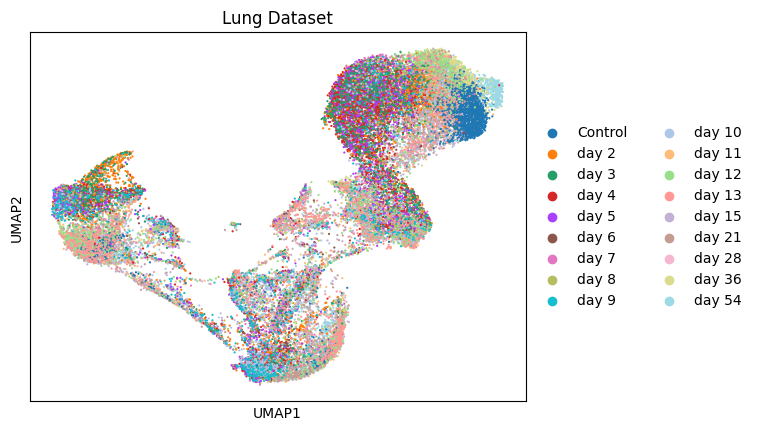

In [109]:
sc.pl.umap(adata, color='time_point', s = 10, add_outline = False, title = 'Lung Dataset')


[2023-10-11 00:40:46,153] [INFO    ] Computing nearest neighbor distances.
[2023-10-11 00:40:46,162] [INFO    ] Using covariance function Matern52(ls=0.003668950521097953).
[2023-10-11 00:40:46,163] [INFO    ] Doing full-rank Cholesky decomposition for 2,376 samples.
[2023-10-11 00:40:46,870] [INFO    ] Using rank 2,376 covariance representation.
[2023-10-11 00:40:47,170] [INFO    ] Running inference using L-BFGS-B.
[2023-10-11 00:40:48,034] [INFO    ] Computing predictive function.


<timed exec>:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


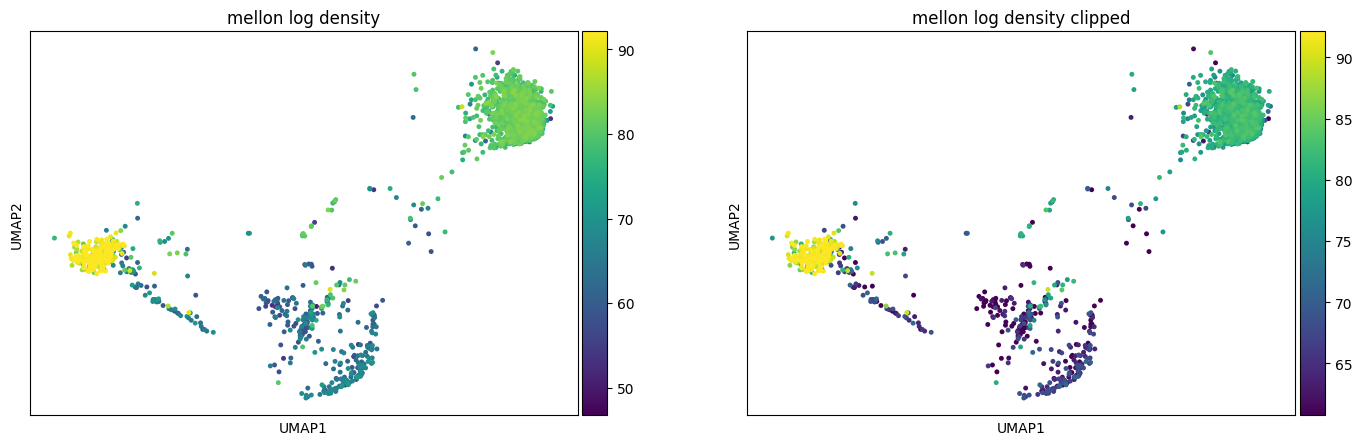

CPU times: user 6.12 s, sys: 28.2 s, total: 34.4 s
Wall time: 11 s


In [26]:

%%time
adata_sub1 = adata[ adata.obs['time_point'] == 'Control']
model = mellon.DensityEstimator()
log_density = model.fit_predict(adata_sub1.obsm["DM_EigenVectors"])

predictor1 = model.predict(adata.obsm['DM_EigenVectors'])

adata_sub1.obs["mellon_log_density"] = log_density
adata_sub1.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)
sc.pl.scatter(
    adata_sub1, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap")

#fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
#sc.pl.violin(adata_sub, "mellon_log_density", "sub_cluster3", rotation=45, ax=ax1, show=False)
#sc.pl.scatter(adata_sub, color="sub_cluster3", basis="umap", ax=ax2, show=False,  legend_loc ='on data' )
#plt.show()


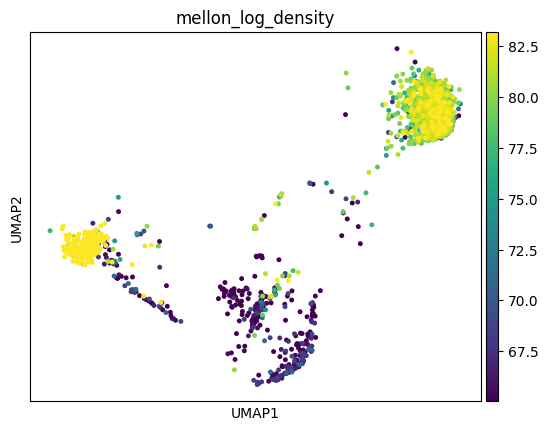

In [11]:
sc.pl.umap(adata_sub1, color=["mellon_log_density"], vmin="p10", vmax = 'p90')

[2023-10-11 00:41:10,827] [INFO    ] Computing nearest neighbor distances.
[2023-10-11 00:41:10,832] [INFO    ] Using covariance function Matern52(ls=0.005928591425442338).
[2023-10-11 00:41:10,833] [INFO    ] Doing full-rank Cholesky decomposition for 879 samples.
[2023-10-11 00:41:10,863] [INFO    ] Using rank 879 covariance representation.
[2023-10-11 00:41:10,877] [INFO    ] Running inference using L-BFGS-B.
[2023-10-11 00:41:11,437] [INFO    ] Computing predictive function.


<timed exec>:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


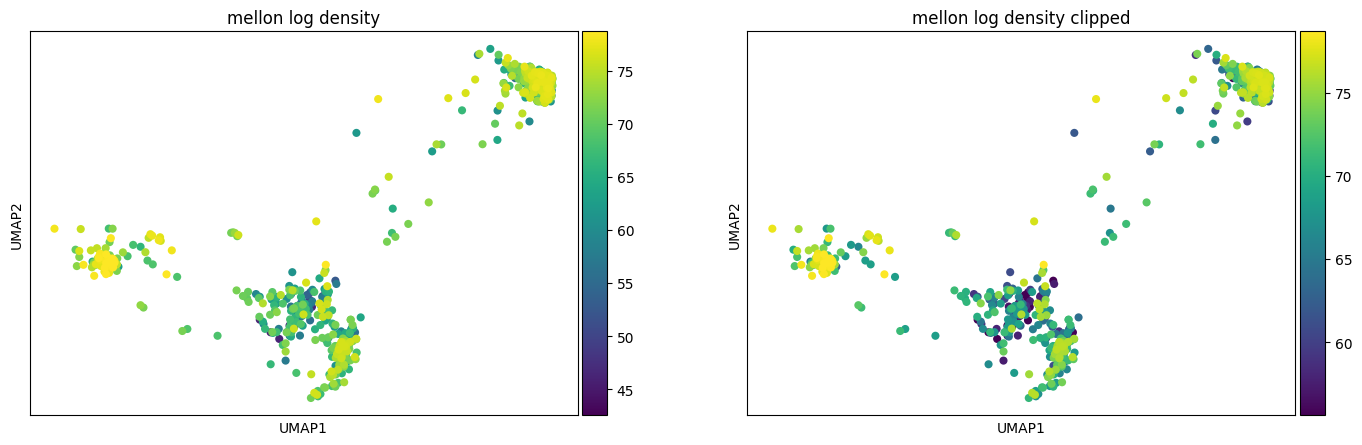

CPU times: user 2.17 s, sys: 9.06 s, total: 11.2 s
Wall time: 3.57 s


In [27]:
%%time
adata_sub2 = adata[ adata.obs['time_point'] == 'day 54']
model = mellon.DensityEstimator()
log_density = model.fit_predict(adata_sub2.obsm["DM_EigenVectors"])

predictor2 = model.predict(adata.obsm['DM_EigenVectors'])

adata_sub2.obs["mellon_log_density"] = log_density
adata_sub2.obs["mellon_log_density_clipped"] = np.clip(log_density, *np.quantile(log_density, [0.05, 1]))
sc.pl.scatter(adata_sub2, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap")

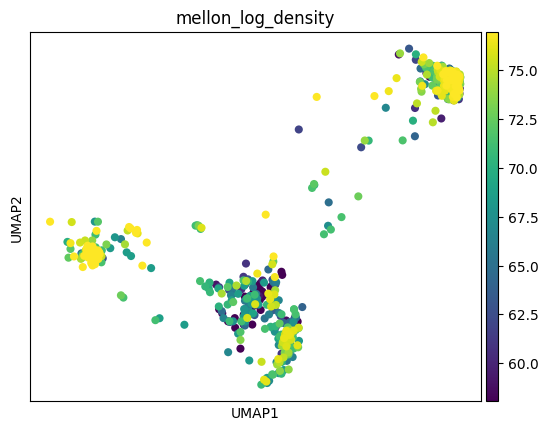

In [13]:
sc.pl.umap(adata_sub2, color=["mellon_log_density"], vmin="p10", vmax = 'p90')

In [42]:
adata.obs['predictor_control'] = predictor1
adata.obs['predictor_d54'] = predictor2


In [43]:
adata3 = adata[adata.obs['time_point'].isin(['Control', 'day 54'])]

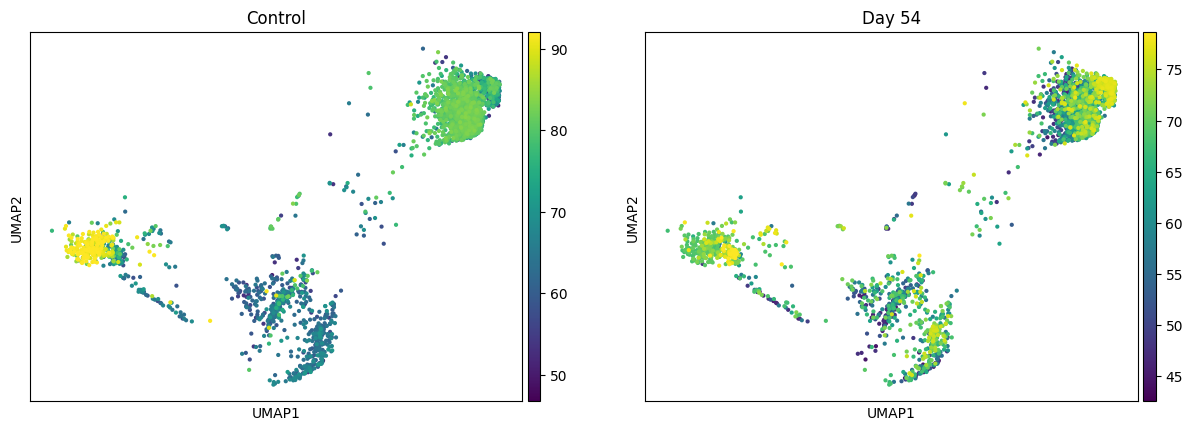

In [55]:
sc.pl.umap(adata3, color=["predictor_control", 'predictor_d54'],  title = ['Control', 'Day 54'])

/tmp/ipykernel_1425/1430308184.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  matplotlib.cm.get_cmap()


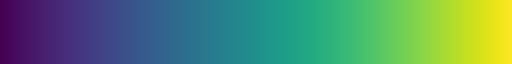

In [84]:
import matplotlib
matplotlib.cm.get_cmap()

/home/lufesu/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/lufesu/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


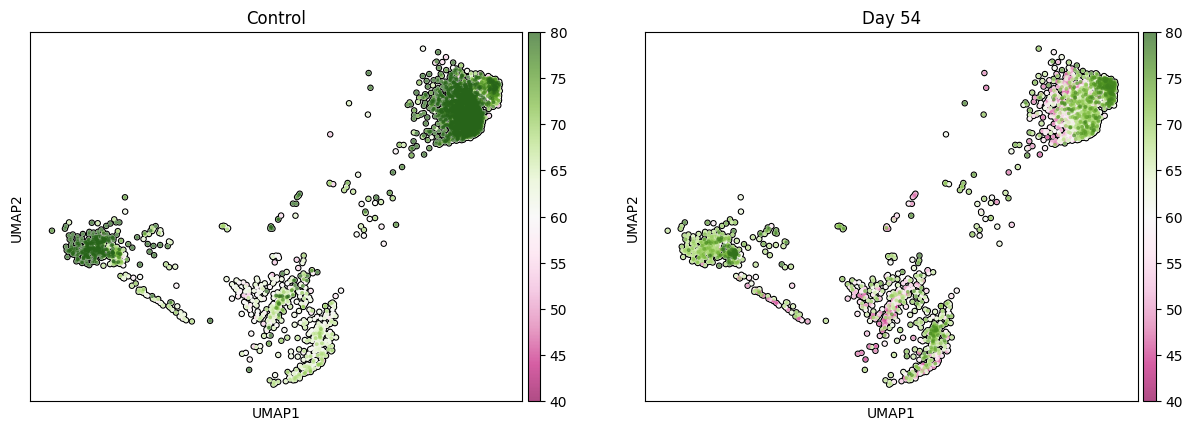

In [107]:
sc.pl.umap(adata3, color_map ='PiYG', color=["predictor_control", 'predictor_d54'], vmin = [40, 40], vmax = [80, 80], title = ['Control', 'Day 54'], s = 30, add_outline= True)

In [39]:
adata_pancreatic = sc.read_text('GSE181276_genes.counts_for_GEO_uploading.txt')

In [47]:
import anndata

adata2 = anndata.AnnData(adata_pancreatic.to_df().values.T)
adata2.obs_names = adata_pancreatic.var_names
adata2.var_names = adata_pancreatic.obs_names

In [61]:
adata2.obs = pd.DataFrame({ 'Barcode': [i.split('_')[-1] for i in cells],
    'Type' : [i.split('_')[0] for i in cells] })

In [106]:
adata2.obs['Type'] =adata2.obs['Type'].astype('str')
adata2.obs.loc[adata2.obs['Type'] == 'WT', 'Type'] = 'Control'
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Control', 'D1', 'D7', 'D28'], ordered=True)
adata2.obs['Type'] = adata2.obs['Type'].astype(cat_type)

In [107]:
#sc.write(filename = 'raw_pancreatic.h5', adata = adata2, ext='h5')

In [121]:
adata2 = sc.read_h5ad('raw_pancreatic.h5')

In [111]:
#sc.pp.filter_cells(adata2, min_counts=1)
#sc.pp.filter_genes(adata2, min_cells=10)
#sc.pp.normalize_total(adata2)
#sc.pp.log1p(adata2)
#sc.pp.highly_variable_genes(adata2, n_top_genes = 2000)
#sc.pp.pca(adata2, use_highly_variable=True)
#sc.pp.neighbors(adata2, n_neighbors=30)


/home/lufesu/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lufesu/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lufesu/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

In [117]:
#sc.tl.umap(adata2, n_components = 20)

In [127]:
communities = sc.external.tl.phenograph(adata2, k=50, clustering_algo = 'leiden', seed = 0, copy=True)
adata2.obs['pheno_20'] = pd.Categorical(communities[0])

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 28.345908641815186 seconds


OSError: [Errno 12] Cannot allocate memory

In [124]:
adata2

AnnData object with n_obs × n_vars = 33681 × 31053
    obs: 'Barcode', 'Type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/home/lufesu/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


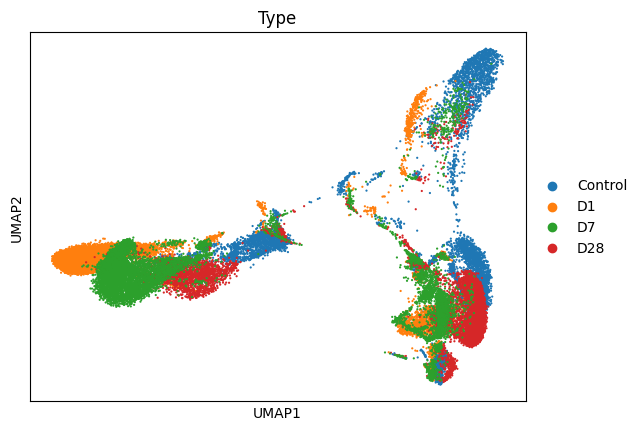

In [128]:
sc.pl.umap(adata2, color=['Type'], s = 10, vmin = 'p10', vmax = 'p90')
